In [16]:
import os
import numpy as np
from skimage.io import imread, imread_collection
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, Sequential
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

SEED = 67
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
DATA_PATH = "../data"
TEST_PERCENT = .7
VAL_PERCENT = .15
SVM_SUBSET_SIZE = 1000

np.random.seed(SEED)
tf.random.set_seed(SEED)

<h1>Arrange Data</h1>

In [2]:

dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    image_size=IMG_SIZE,
    seed=SEED,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Normalize the pixels
# dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

# Split the datasets after loading in a shuffled version
total_batches = tf.data.experimental.cardinality(dataset).numpy()

train_size = int(TEST_PERCENT * total_batches)
val_size   = int(VAL_PERCENT * total_batches)
test_size  = total_batches - train_size - val_size

train_ds = dataset.take(train_size)
val_ds   = dataset.skip(train_size).take(val_size)
test_ds  = dataset.skip(train_size + val_size)

# SVM uses k-fold validation, so it should use the whole training set
full_train_ds = train_ds.concatenate(val_ds)


Found 5856 files belonging to 3 classes.


<h1>Visualize model training</h1>

In [3]:
def plot_training_curves(history, title_prefix="Model"):
    """Plot training & validation accuracy and loss (separate charts)."""
    # Accuracy plot
    plt.figure()
    plt.plot(history.history.get("accuracy", []), label="train_acc")
    if "val_accuracy" in history.history:
        plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.title(f"{title_prefix} — Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Loss plot
    plt.figure()
    plt.plot(history.history.get("loss", []), label="train_loss")
    if "val_loss" in history.history:
        plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(f"{title_prefix} — Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# SVM

In [ ]:
# convert data to numpy arrays so SVM can use it
def dataset_to_numpy(ds):
    X, y = [], []
    for images, labels in ds:
        X.append(images.numpy())
        y.append(labels.numpy())
    X = np.concatenate(X)
    y = np.concatenate(y)
    X = X.reshape((X.shape[0], -1)) / 255.0
    return X, y
X_train, y_train = dataset_to_numpy(full_train_ds)
X_test, y_test = dataset_to_numpy(test_ds)


In [17]:
# SVM is really slow on big data, so take a subset
X_train_sub = X_train[:SVM_SUBSET_SIZE]
y_train_sub = y_train[:SVM_SUBSET_SIZE]

In [18]:
# SVM
svm_grid = GridSearchCV(
    SVC(random_state=SEED, coef0=1),
    {
        "kernel": ["poly", "rbf"],
        "C": [1e-2, 1e-1, 1e0],
        "degree": [1, 2, 3]
    },
    cv=3,
    scoring='matthews_corrcoef',
    n_jobs=-1
)
svm_grid.fit(X_train_sub, y_train_sub)
svm_params, svm_score = svm_grid.best_params_, svm_grid.best_score_

print("SVM best parameters: ", svm_params)
print("Resulting MCC score: ", svm_score)

SVM best parameters:  {'C': 1.0, 'degree': 1, 'kernel': 'rbf'}
Resulting MCC score:  0.6443513728091438


<h1>Simple CNN</h1>

Epoch 1/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 40s 283ms/step - accuracy: 0.6785 - loss: 41.0496 - val_accuracy: 0.7361 - val_loss: 0.6335
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 218ms/step - accuracy: 0.7991 - loss: 0.4828 - val_accuracy: 0.7743 - val_loss: 0.5871
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 214ms/step - accuracy: 0.8384 - loss: 0.3815 - val_accuracy: 0.7755 - val_loss: 0.6021
Epoch 4/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 29s 224ms/step - accuracy: 0.8677 - loss: 0.3369 - val_accuracy: 0.7639 - val_loss: 0.6258
Epoch 5/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 29s 228ms/step - accuracy: 0.8933 - loss: 0.2641 - val_accuracy: 0.7535 - val_loss: 0.7700
Epoch 6/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 218ms/step - accuracy: 0.9143 - loss: 0.2185 - val_accuracy: 0.7801 - val_loss: 0.6908
Epoch 7/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 228ms/step - accuracy: 0.9246 - loss: 0.1858 - val_accuracy: 0.7141 - val_loss: 1.0265
Epoch 8/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 215ms/step - accuracy: 0.8733 - loss: 

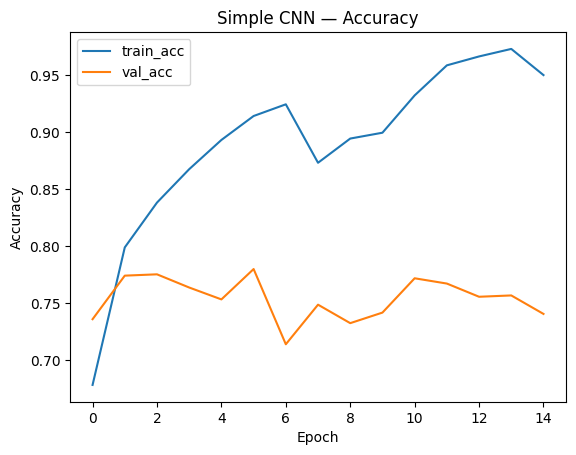

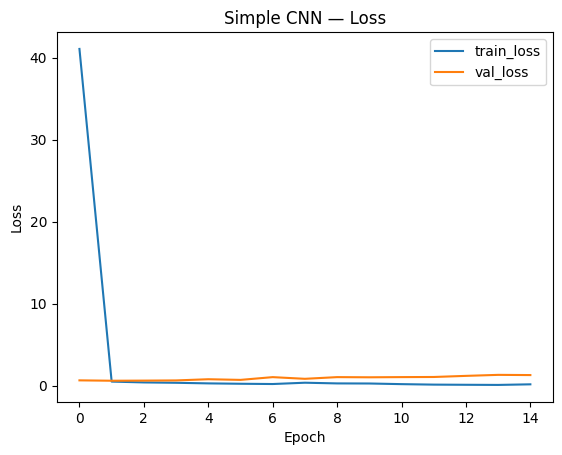

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,228,256 (96.24 MB)

 Trainable params: 8,409,418 (32.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,818,838 (64.16 MB)

In [11]:
cnn_simple = Sequential([
    layers.Input(shape=(IMG_SIZE + (3,))),
    layers.Conv2D(32, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax"),
])

cnn_simple.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


history_cnn_simple = cnn_simple.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    verbose=1
)

plot_training_curves(history_cnn_simple, title_prefix="Simple CNN")
cnn_simple.summary()